# Imports


In [ ]:
# System and OS utilities
import os
from collections import defaultdict
from google.colab import drive

# Data manipulation and processing
import numpy as np
import pandas as pd

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import (
    ResNet50, EfficientNetB0, InceptionV3, InceptionResNetV2, DenseNet121
)
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M


# Scikit-learn for data preprocessing and splitting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Image processing
from PIL import Image

# Utility libraries
from tqdm import tqdm

import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
drive.mount('/content/drive')

# Load the images
data_dir = '/content/drive/MyDrive/HHD_AgeSplit'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Load the CSV file
csv_dir = os.path.join(data_dir, 'NewAgeSplit.csv')
labels_data = pd.read_csv(csv_dir)

Mounted at /content/drive


In [ ]:
# Fit the scaler on the entire age column (or only on the training split)
scaler = MinMaxScaler()
labels_data['ScaledAge'] = scaler.fit_transform(labels_data[['Age']])

In [ ]:
BATCH_SIZE = 128
TRAIN_EPOCHS = 50
FINETUNE_EPOCHS = 20

# Training


## Loading Images and Preprocessing


In [ ]:
def calculate_resized_dimensions(height, width, patch_size=400, stride=200, standard_size=800):
    """
    Calculates resized dimensions to maintain aspect ratio, be compatible with patching, and close to a standard size.

    Args:
        height (int): Original height of the image.
        width (int): Original width of the image.
        patch_size (int): Size of each patch (default 400).
        stride (int): Stride for patching (default 200).
        standard_size (int): Target standard size for the smaller dimension.

    Returns:
        tuple: Resized height and width.
    """
    aspect_ratio = width / height

    # Scale dimensions such that the smaller side matches the standard size
    if height < width:
        new_height = standard_size
        new_width = int(new_height * aspect_ratio)
    else:
        new_width = standard_size
        new_height = int(new_width / aspect_ratio)

    # Adjust dimensions to be compatible with patching
    def adjust_dimension(dim):
        remainder = (dim - patch_size) % stride
        return dim if remainder == 0 else dim - remainder

    new_height = adjust_dimension(new_height)
    new_width = adjust_dimension(new_width)

    return new_height, new_width

In [ ]:
def read_tiff_image_with_dynamic_resize(img_path):
    """
    Reads a TIFF image, dynamically resizes it to be compatible with patches and standard size, and normalizes it.

    Args:
        img_path (tf.Tensor): Path to the image file.

    Returns:
        np.ndarray: Resized and normalized image as a NumPy array.
    """
    img = Image.open(img_path.numpy().decode("utf-8"))  # Load TIFF file
    img = img.convert('RGB')  # Convert to RGB if necessary
    original_size = img.size  # Original dimensions (width, height)
    new_height, new_width = calculate_resized_dimensions(original_size[1], original_size[0])
    img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)  # Resize dynamically with LANCZOS
    img_array = np.array(img, dtype=np.float32) / 255.0  # Normalize pixel values
    return img_array

In [ ]:
def process_image(row, data_dir, patch_size, step_size):
    """
    Processes a row to load an image, extract patches, and yield scaled age labels.
    """
    img_path = tf.strings.join([data_dir, row['File']], separator='/')
    try:
        img = tf.py_function(func=read_tiff_image_with_dynamic_resize, inp=[img_path], Tout=tf.float32)
        img.set_shape([None, None, 3])
    except Exception as e:
        tf.print(f"Error processing file: {img_path}", e)
        raise e

    patches = tf.image.extract_patches(
        images=tf.expand_dims(img, 0),
        sizes=[1, patch_size[0], patch_size[1], 1],
        strides=[1, step_size, step_size, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )
    patches = tf.reshape(patches, [-1, patch_size[0], patch_size[1], 3])
    # Use the scaled age label instead of the original age.
    labels = tf.fill([tf.shape(patches)[0]], row['ScaledAge'])
    return patches, labels

In [ ]:
def patch_data_tf_dataset(
    data_dir, labels_df, dataset_type, patch_size=(400, 400), step_size=200, batch_size=BATCH_SIZE, augment=False
):
    """
    Creates a TensorFlow dataset for loading and preprocessing images, including patch extraction.

    Args:
        data_dir (str): Directory containing the images.
        labels_df (pd.DataFrame): DataFrame with file paths and labels.
        dataset_type (str): Subset type ('train', 'val', 'test').
        patch_size (tuple): Size of each patch (height, width).
        step_size (int): Step size for extracting patches.
        batch_size (int): Number of samples per batch.
        augment (bool): Whether to apply data augmentation.

    Returns:
        tf.data.Dataset: A TensorFlow dataset for training or evaluation.
    """
    subset_df = labels_df[labels_df['Set'] == dataset_type].reset_index(drop=True)
    dataset = tf.data.Dataset.from_tensor_slices(dict(subset_df))

    # Map the function to process each row
    dataset = dataset.map(
        lambda row: process_image(row, data_dir, patch_size, step_size),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Flatten dataset to yield patches
    dataset = dataset.flat_map(
        lambda patches, labels: tf.data.Dataset.zip(
            (tf.data.Dataset.from_tensor_slices(patches), tf.data.Dataset.from_tensor_slices(labels))
        )
    )

    # Apply augmentation if needed
    if augment:
        # Apply our advanced augmentation instead of just flipping.
        dataset = dataset.map(
            lambda patch, label: advanced_augmentation(patch, label),
            num_parallel_calls=tf.data.AUTOTUNE
        )


    # Batch and prefetch
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
# Create the RandomRotation layer outside the augmentation function.
rotation_layer = tf.keras.layers.RandomRotation(factor=(-0.04167, 0.04167))

translation_layer = tf.keras.layers.RandomTranslation(
        height_factor=0.1,
        width_factor=0.1,
        fill_mode='constant',
        fill_value=1.0)  # Use fill_value instead of constant_values

def advanced_augmentation(image, label,
                          rotation_factor=(-0.04167, 0.04167),  # ±15° rotation
                          zoom_range=(1.0, 1.2),                 # Zoom in only
                          brightness_delta=0.2,
                          contrast_range=(0.8, 1.2),
                          noise_std=0.2,
                          translation_height=0.1,              # Up to 10% vertical shift
                          translation_width=0.1):              # Up to 10% horizontal shift
    """
    Applies advanced augmentations with parameterized options for black & white handwriting images.

    Args:
        image: Input image tensor in [0,1] range.
        label: Associated label.
        rotation_factor: Tuple specifying the min and max fractional rotation.
        zoom_range: Tuple specifying the min and max zoom factors (zooming in only).
        brightness_delta: Maximum delta for random brightness.
        contrast_range: Tuple for lower and upper bounds in random contrast.
        noise_std: Standard deviation for Gaussian noise.
        translation_height: Fraction of total height to shift vertically.
        translation_width: Fraction of total width to shift horizontally.

    Returns:
        Augmented (image, label) pair.
    """
    # Random Rotation
    image = rotation_layer(image, training=True)

    # Random Zoom (zoom in only)
    orig_shape = tf.shape(image)[:2]
    zoom_factor = tf.random.uniform([], zoom_range[0], zoom_range[1])
    new_size = tf.cast(tf.cast(orig_shape, tf.float32) * zoom_factor, tf.int32)
    image = tf.image.resize(image, new_size)
    # Crop or pad back to the original dimensions
    image = tf.image.resize_with_crop_or_pad(image, orig_shape[0], orig_shape[1])

    # Random Translation: shifts image while filling empty areas with white.
    image = translation_layer(image, training=True)

    # Random Brightness
    image = tf.image.random_brightness(image, max_delta=brightness_delta)

    # Random Contrast
    image = tf.image.random_contrast(image, lower=contrast_range[0], upper=contrast_range[1])

    # Add Gaussian Noise
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=noise_std)
    image = image + noise
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label


## Test Augmentation


In [ ]:
# import matplotlib.pyplot as plt
# from PIL import Image
# import numpy as np

# # Assuming you have an image and label ready
# # Example:
# image_path = "/content/w1_F_4_form1.tif" # Replace with your actual image
# label = 0  # Replace with your actual label

# # Load and preprocess the image before applying augmentation
# img = Image.open(image_path)
# img = img.convert('RGB')  # Convert to RGB if necessary
# img_array = np.array(img, dtype=np.float32) / 255.0  # Normalize pixel values

# for i in range(10):
#     # Apply the augmentation
#     augmented_image, augmented_label = advanced_augmentation(img_array, label)

#     # Convert the augmented image to a NumPy array for display
#     augmented_image_np = augmented_image.numpy()

#     # Display the augmented image
#     plt.imshow(augmented_image_np)
#     plt.axis('off')  # Hide axes
#     plt.show()

## Train

In [ ]:
# Define a function to create models using SOTA architectures
def build_sota_model(base_model_fn, input_shape=(400, 400, 3), dropout_rate=0.5):
    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model initially

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)  # Regression output

    model = Model(inputs, outputs)
    return model

In [ ]:
# Training generator with augmentation
train_dataset = patch_data_tf_dataset(
    data_dir=train_dir,
    labels_df=labels_data,
    dataset_type='train',
    patch_size=(400, 400),
    step_size=200,
    batch_size=BATCH_SIZE,
    augment=True  # Enable augmentation
)

# Validation generator without augmentation
val_dataset = patch_data_tf_dataset(
    data_dir=val_dir,
    labels_df=labels_data,
    dataset_type='val',
    patch_size=(400, 400),
    step_size=200,
    batch_size=BATCH_SIZE,
    augment=False
)

In [ ]:
training_dir = os.path.join(data_dir, 'ensemble_training_more_augmentation_scaling_lr_schedule')

# Define SOTA models
models = {
    # 'ResNet50': build_sota_model(ResNet50),
    'InceptionV3': build_sota_model(InceptionV3),
    # 'InceptionResNetV2': build_sota_model(InceptionResNetV2),
    'DenseNet121': build_sota_model(DenseNet121),
    # 'EfficientNetV2M': build_sota_model(EfficientNetV2M)
}

trained_models = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=10000,
        decay_rate=0.96,
        staircase=True
        )

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    # Compile the model
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    # Define callbacks
    checkpoint = ModelCheckpoint(f"{training_dir}/{model_name}_best_model.keras", monitor='val_loss', save_best_only=True, mode='min')
    # reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

    # Train the model
    model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=TRAIN_EPOCHS,
        callbacks=[checkpoint, early_stopping]
    )

    # Unfreeze and fine-tune the base model
    model.layers[1].trainable = True

    # Create a new optimizer with a lower learning rate for fine tuning, e.g., 1e-4
    fine_tune_lr = 1e-4
    optimizer_ft = tf.keras.optimizers.Adam(learning_rate=fine_tune_lr)

    # Recompile the model with the new, lower learning rate
    model.compile(optimizer=optimizer_ft, loss='mse', metrics=['mae'])

    # Fine tune the model
    model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=FINETUNE_EPOCHS,
        callbacks=[checkpoint, early_stopping]
    )


Training InceptionV3...
Epoch 1/50
     97/Unknown 118s 962ms/step - loss: 0.4820 - mae: 0.5536

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


97/97 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - loss: 0.4812 - mae: 0.5531 - val_loss: 0.0543 - val_mae: 0.1867
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 89s 916ms/step - loss: 0.2838 - mae: 0.4242 - val_loss: 0.0400 - val_mae: 0.1463
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 90s 921ms/step - loss: 0.2084 - mae: 0.3652 - val_loss: 0.0355 - val_mae: 0.1342
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 88s 903ms/step - loss: 0.1793 - mae: 0.3400 - val_loss: 0.0396 - val_mae: 0.1432
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 90s 925ms/step - loss: 0.1480 - mae: 0.3097 - val_loss: 0.0314 - val_mae: 0.1209
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 90s 916ms/step - loss: 0.1314 - mae: 0.2953 - val_loss: 0.0289 - val_mae: 0.1114
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 90s 917ms/step - loss: 0.1128 - mae: 0.2741 - val_loss: 0.0288 - val_mae: 0.1125
Epoch 8/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 90s 919ms/step - loss: 0.1146 - mae: 0.2782 - val_loss: 0.0278 - val_mae: 0.1109
Epoch 9/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 89s 913ms/step - loss: 

# Evaluation


## Methods

In [ ]:
def process_row_with_id(row):
    """
    Processes a row to generate patches, labels, and use 'File' as the ImageID.
    """
    # Load patches and labels
    patches, labels = process_image(row, test_dir, (400,400), 200)

    # Use 'File' as the ImageID
    image_id = tf.fill([tf.shape(patches)[0]], row['File'])
    return patches, labels, image_id

In [ ]:
def patch_data_tf_dataset_with_ids(
    data_dir, labels_df, dataset_type, patch_size=(400, 400), step_size=200, batch_size=BATCH_SIZE, augment=False
):
    """
    Creates a TensorFlow dataset with patches and 'File' as ImageID.
    """
    subset_df = labels_df[labels_df['Set'] == dataset_type].reset_index(drop=True)
    dataset = tf.data.Dataset.from_tensor_slices(dict(subset_df))

    # Map the function to process rows
    dataset = dataset.map(
        process_row_with_id,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Flatten dataset to yield individual patches
    dataset = dataset.flat_map(
        lambda patches, labels, image_id: tf.data.Dataset.zip(
            (
                tf.data.Dataset.from_tensor_slices(patches),
                tf.data.Dataset.from_tensor_slices(labels),
                tf.data.Dataset.from_tensor_slices(image_id) # Keep image_id here
            )
        )
    )

    # Apply augmentation if required
    if augment:
        dataset = dataset.map(
            lambda patch, label, image_id: (tf.image.random_flip_left_right(patch), label, image_id),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch and prefetch
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def compute_evaluation_metrics(true_images_scaled, predicted_images_scaled):
    # Inverse transform to original age scale.
    predicted_images_original = scaler.inverse_transform(predicted_images_scaled.reshape(-1, 1)).flatten()
    true_images_original = scaler.inverse_transform(true_images_scaled.reshape(-1, 1)).flatten()

    # Compute metrics on the original scale
    mae = mean_absolute_error(true_images_original, predicted_images_original)
    rmse = np.sqrt(mean_squared_error(true_images_original, predicted_images_original))
    r2 = r2_score(true_images_original, predicted_images_original)
    mape = np.mean(np.abs((true_images_original - predicted_images_original) / true_images_original)) * 100

    # Threshold calculations using original values
    def percent_within_threshold(y_true, y_pred, threshold):
        errors = np.abs(y_true - y_pred)
        within = np.sum(errors <= threshold)
        return (within / len(y_true)) * 100

    within_2 = percent_within_threshold(true_images_original, predicted_images_original, 2)
    within_5 = percent_within_threshold(true_images_original, predicted_images_original, 5)
    within_10 = percent_within_threshold(true_images_original, predicted_images_original, 10)

    # Additional statistics
    errors = np.abs(true_images_original - predicted_images_original)
    max_error = np.max(errors)
    median_error = np.median(errors)
    cumulative_error_5 = np.mean(errors <= 5) * 100

    metrics = {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "MAPE": mape,
        "Within ±2 Years (%)": within_2,
        "Within ±5 Years (%)": within_5,
        "Within ±10 Years (%)": within_10,
        "Max Error": max_error,
        "Median Error": median_error,
        "Cumulative Error ≤ 5 Years (%)": cumulative_error_5,
    }

    for key, value in metrics.items():
        print(f"{key}: {value:.2f}")

    # Create plots
    errors_sorted = np.sort(errors)
    cumulative_percentage = np.arange(1, len(errors_sorted) + 1) / len(errors_sorted) * 100

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Error Distribution Plot
    axs[0].hist(errors, bins=20, edgecolor='black')
    axs[0].set_title('Error Distribution')
    axs[0].set_xlabel('Prediction Error (Years)')
    axs[0].set_ylabel('Frequency')

    # Cumulative Error Distribution Plot
    axs[1].plot(errors_sorted, cumulative_percentage)
    axs[1].set_title('Cumulative Error Distribution')
    axs[1].set_xlabel('Absolute Error (Years)')
    axs[1].set_ylabel('Cumulative Percentage (%)')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

    return metrics

In [ ]:
def group_predictions_by_image_id(predictions_with_ids, labels_df):
    """
    ---- Modification 3: Use 'ScaledAge' instead of original 'Age'
    Groups predictions by their image_id.
    """
    grouped_predictions = defaultdict(list)
    grouped_labels = defaultdict(list)
    for pred, image_id in predictions_with_ids:
        image_id_str = image_id.decode('utf-8')
        grouped_predictions[image_id_str].append(pred)
    for _, row in labels_df.iterrows():
        file_id = row['File']
        if file_id in grouped_predictions:
            grouped_labels[file_id].append(row['ScaledAge'])
    common_ids = set(grouped_predictions.keys()) & set(grouped_labels.keys())
    predicted_images = [np.mean(grouped_predictions[img_id]) for img_id in common_ids]
    true_images = [np.mean(grouped_labels[img_id]) for img_id in common_ids]
    return np.array(predicted_images), np.array(true_images)

In [ ]:
def ensemble_predict(models, test_data):
    """
    Makes predictions using an ensemble of models by averaging their outputs.
    Args:
        models (dict): A dictionary of trained models.
        test_data (tf.data.Dataset): Test dataset.
    Returns:
        list: A list of tuples containing predictions and image IDs.
    """
    predictions = []
    for batch in test_data:
        patches, _, image_ids = batch

        batch_preds = [model.predict(patches, verbose=0) for model in models.values()]
        avg_preds = np.mean(batch_preds, axis=0)
        predictions.extend(zip(avg_preds.flatten(), image_ids.numpy()))

    return predictions

In [ ]:
def ensemble_predict_with_weights(models, test_data, weights=None):
    """
    Makes predictions using an ensemble of models by computing a weighted average of their outputs.

    Args:
        models (dict): A dictionary of trained models.
        test_data (tf.data.Dataset): Test dataset.
        weights (dict, optional): A dictionary mapping model names to their weights.
                                  If None, each model is given equal weight.

    Returns:
        list: A list of tuples containing the weighted average predictions and image IDs.
    """
    predictions = []

    # If no weights provided, assign equal weights to all models.
    if weights is None:
        weights = {name: 1.0 for name in models.keys()}

    # Normalize weights so they sum to 1.
    total_weight = sum(weights.values())
    normalized_weights = {name: weight / total_weight for name, weight in weights.items()}

    for batch in test_data:
        patches, _, image_ids = batch

        # Initialize weighted predictions with zeros.
        batch_preds_weighted = np.zeros((patches.shape[0], 1))

        # Accumulate predictions from each model multiplied by its normalized weight.
        for model_name, model in models.items():
            model_weight = normalized_weights.get(model_name, 0)
            preds = model.predict(patches, verbose=0)
            batch_preds_weighted += model_weight * preds

        # Append weighted predictions along with corresponding image IDs.
        predictions.extend(zip(batch_preds_weighted.flatten(), image_ids.numpy()))

    return predictions

In [ ]:
def evaluate_individual_model(model, test_dataset, labels_df):
    """
    Evaluates a single model's performance on a test dataset, grouping predictions by image ID.

    Args:
        model (tf.keras.Model): The trained model to evaluate.
        test_dataset (tf.data.Dataset): Dataset containing test patches, labels, and image IDs.
        labels_df (pd.DataFrame): DataFrame with true labels and file IDs.

    Returns:
        dict: Evaluation metrics including MAE, RMSE, R², MAPE, and thresholds.
    """
    predictions_with_ids = []

    for batch in test_dataset:
        patches, _, image_ids = batch
        predictions = model.predict(patches, verbose=0).flatten()
        predictions_with_ids.extend(zip(predictions, image_ids.numpy()))

    predicted_images, true_images = group_predictions_by_image_id(predictions_with_ids, labels_df)

    return compute_evaluation_metrics(true_images, predicted_images)

## Load Models and Test Set


In [ ]:
trained_models = {
    'ResNet50': tf.keras.models.load_model('/content/drive/MyDrive/HHD_AgeSplit/ensemble_training_more_augmentation_scaling_lr_schedule/ResNet50_best_model.keras'),
    'InceptionV3': tf.keras.models.load_model('/content/drive/MyDrive/HHD_AgeSplit/ensemble_training_more_augmentation_scaling_lr_schedule/InceptionV3_best_model.keras'),
    # 'InceptionResNetV2': tf.keras.models.load_model('/content/drive/MyDrive/New_HHD_AgeSplit/ensemble_training_more_augmentation_scaling_lr_schedule/InceptionResNetV2_best_model.keras'),
    'DenseNet121': tf.keras.models.load_model('/content/drive/MyDrive/HHD_AgeSplit/ensemble_training_more_augmentation_scaling_lr_schedule/DenseNet121_best_model.keras'),
    # 'EfficientNetV2M': tf.keras.models.load_model('/content/drive/MyDrive/New_HHD_AgeSplit/ensemble_training_more_augmentation_scaling_lr_schedule/EfficientNetV2M_best_model.keras')
}

In [ ]:
# Test generator without augmentation
test_dataset = patch_data_tf_dataset_with_ids(
    data_dir=test_dir,
    labels_df=labels_data,
    dataset_type='test',
    patch_size=(400, 400),
    step_size=200,
    batch_size=BATCH_SIZE,
    augment=False
)

## Run Evaluations


### Ensemble Metrics

In [ ]:
weights = {
    'ResNet50': 0.7,
    # 'InceptionV3': 0.15,
    'DenseNet121': 0.3,
}

In [ ]:
# Generate predictions with image IDs
# ensemble_predictions_with_ids = ensemble_predict_with_weights(trained_models, test_dataset, weights)

In [ ]:
# Generate predictions with image IDs
ensemble_predictions_with_ids = ensemble_predict(trained_models, test_dataset)

MAE: 4.93
RMSE: 6.71
R2: -0.13
MAPE: 29.52
Within ±2 Years (%): 9.48
Within ±5 Years (%): 69.83
Within ±10 Years (%): 96.55
Max Error: 30.18
Median Error: 3.88
Cumulative Error ≤ 5 Years (%): 69.83


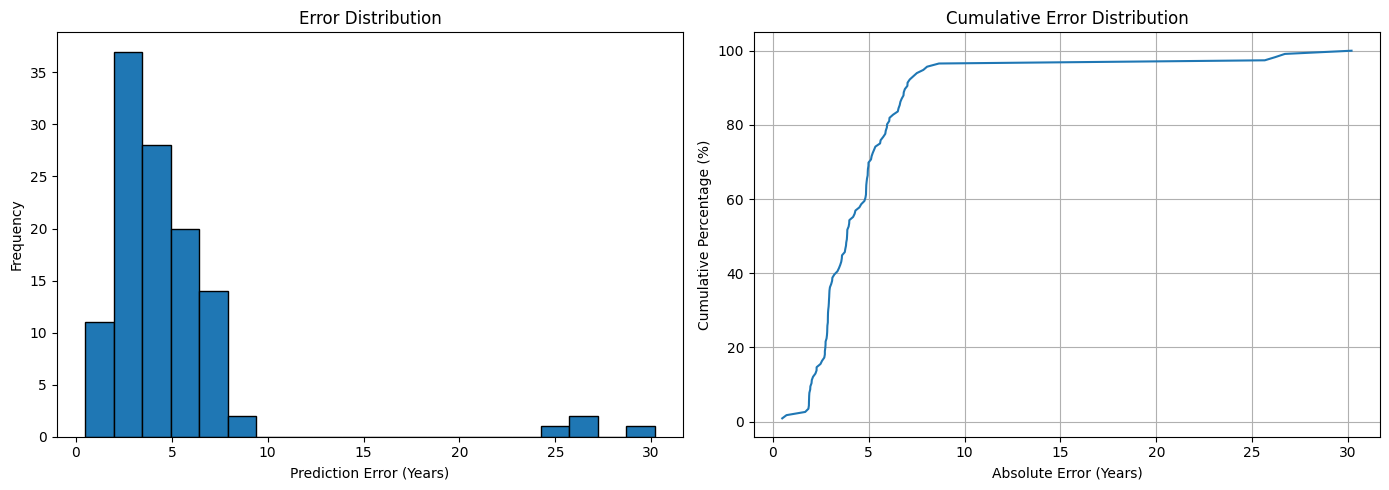

In [ ]:
# Group prediction by image
predicted_images, true_images = group_predictions_by_image_id(ensemble_predictions_with_ids, labels_data)

# Compute metrics
evaluation_metrics = compute_evaluation_metrics(true_images, predicted_images)

### Individual Model Metrics


Evaluating ResNet50...
MAE: 5.75
RMSE: 7.21
R2: -0.30
MAPE: 35.34
Within ±2 Years (%): 1.72
Within ±5 Years (%): 50.00
Within ±10 Years (%): 95.69
Max Error: 28.86
Median Error: 5.00
Cumulative Error ≤ 5 Years (%): 50.00


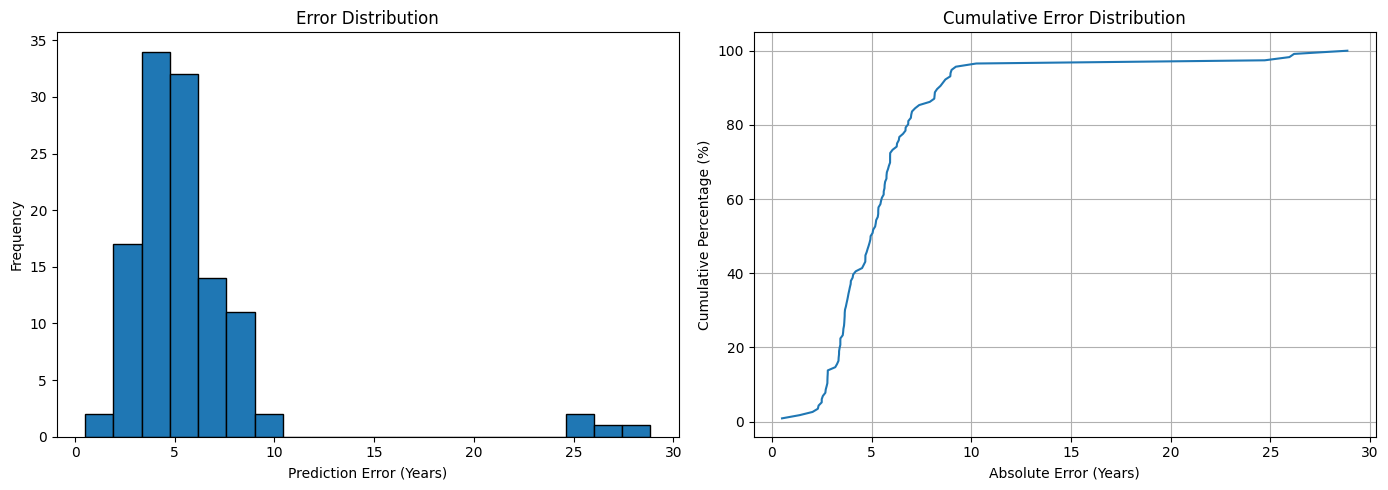





Evaluating InceptionV3...
MAE: 3.42
RMSE: 6.19
R2: 0.04
MAPE: 19.04
Within ±2 Years (%): 44.83
Within ±5 Years (%): 81.03
Within ±10 Years (%): 96.55
Max Error: 32.06
Median Error: 2.47
Cumulative Error ≤ 5 Years (%): 81.03


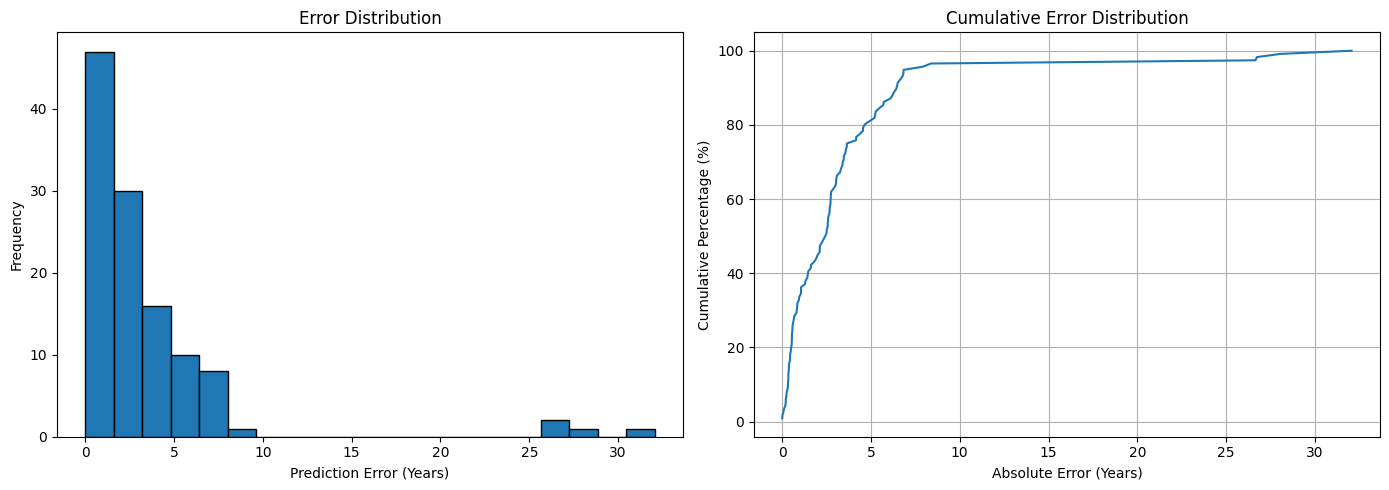





Evaluating DenseNet121...
MAE: 5.73
RMSE: 7.15
R2: -0.28
MAPE: 34.82
Within ±2 Years (%): 2.59
Within ±5 Years (%): 55.17
Within ±10 Years (%): 96.55
Max Error: 29.64
Median Error: 4.82
Cumulative Error ≤ 5 Years (%): 55.17


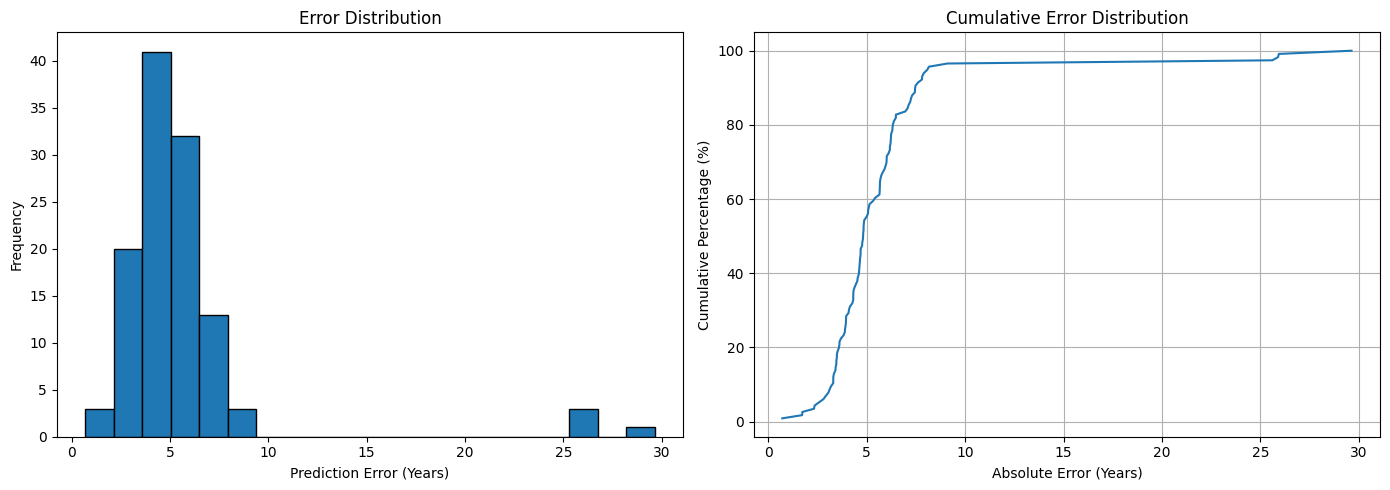

In [ ]:
for model_name, model in trained_models.items():
    print(f"\nEvaluating {model_name}...")
    individual_metrics = evaluate_individual_model(model, test_dataset, labels_data)
    print("\n\n")

# Checks


In [ ]:
# Standardize the predicted image IDs
pred_ids = {os.path.basename(image_id.decode('utf-8')) for _, image_id in ensemble_predictions_with_ids}
test_labels = labels_data[labels_data['Set'] == 'test']
label_ids = set(test_labels['File'])

# Recheck mismatched IDs
missing_preds = label_ids - pred_ids
extra_preds = pred_ids - label_ids

print(f"IDs in labels but missing predictions: {missing_preds}")
print(f"Extra IDs in predictions: {extra_preds}")


IDs in labels but missing predictions: set()
Extra IDs in predictions: set()


In [ ]:
# Filter labels_data for the test set
test_labels_data = labels_data[labels_data['Set'] == 'test']

# Ensure no discrepancies in test labels
print(f"Number of test labels: {len(test_labels_data)}")
print(f"Number of unique files in test_labels_data['File']: {test_labels_data['File'].nunique()}")


Number of test labels: 116
Number of unique files in test_labels_data['File']: 116


In [ ]:
# List of files in test directory
available_files = set(os.listdir(test_dir))

# Check for missing files
missing_files = set(test_labels_data['File']) - available_files
print(f"Files in labels but missing from test directory: {missing_files}")

Files in labels but missing from test directory: set()


In [ ]:
test_labels_data = labels_data[labels_data["Set"] == "test"].copy()

# Which test-set filenames do not exist in test_dir?
missing_from_disk = []
for f in test_labels_data["File"]:
    full_path = os.path.join(test_dir, f)
    if not os.path.exists(full_path):
        missing_from_disk.append(f)

print("Files referenced in CSV but not found on disk:")
print(missing_from_disk)


Files referenced in CSV but not found on disk:
[]


In [ ]:
missing_from_disk = [f for f in test_labels_data["File"]
                     if not os.path.exists(os.path.join(test_dir, f))]
print("Missing from disk:", missing_from_disk)

Missing from disk: []


In [ ]:
# Suppose you pick some test image that is "missing"
some_file = "w78_F_1_form15.tif"
test_path = os.path.join(test_dir, some_file)

print("Test path:", test_path)
print("Exists on disk:", os.path.exists(test_path))

Test path: /content/drive/MyDrive/HHD_AgeSplit/test/w78_F_1_form15.tif
Exists on disk: False
